# Exercise 17: Supernovae distance and redshift
####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.
---

In [1]:
import numpy as np
import pylab as plt

from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


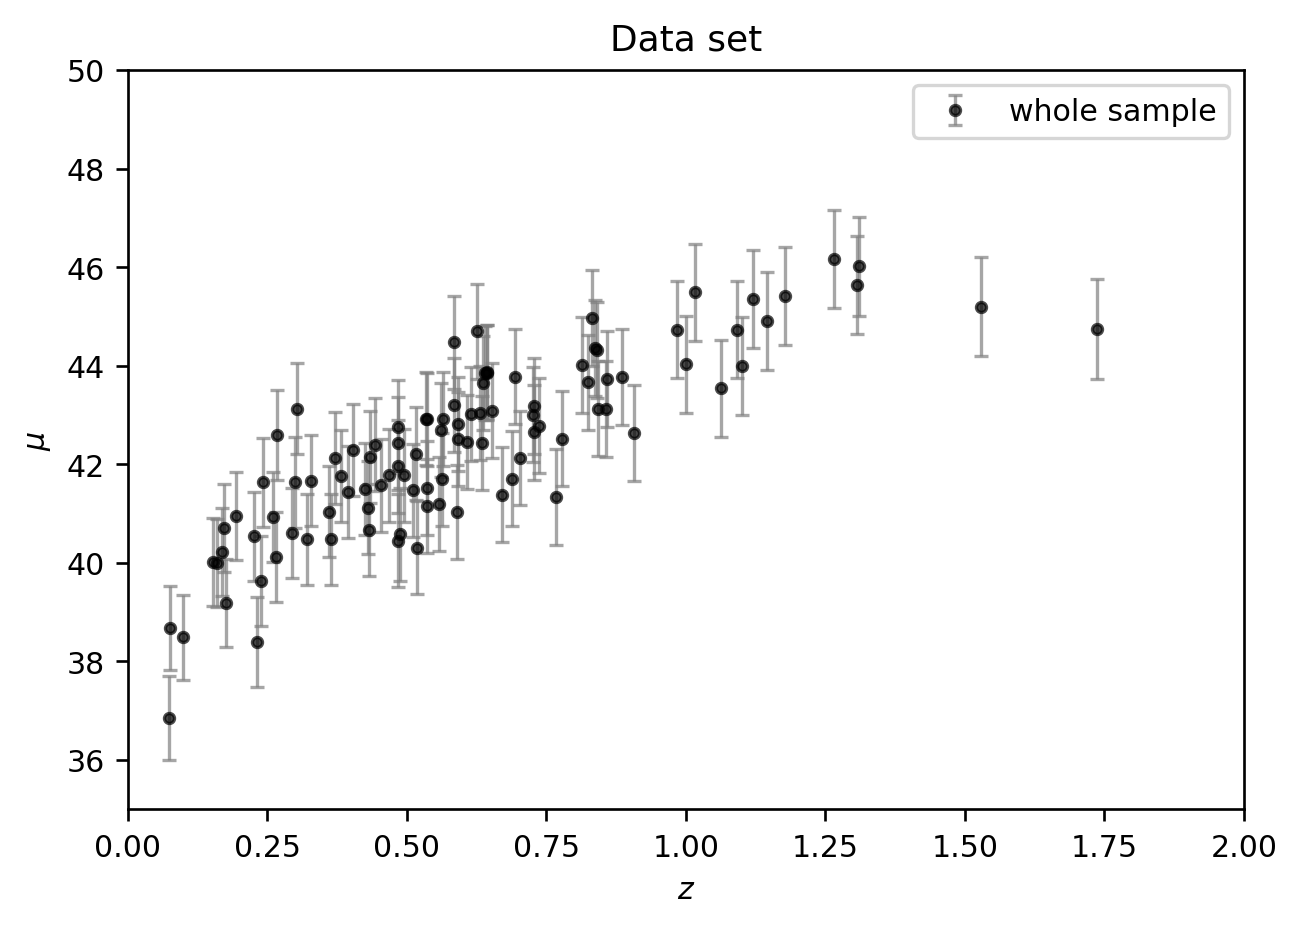

In [2]:
z_sample, mu_sample, dmu = np.asarray(generate_mu_z(100, random_state=1234))

#sorting the sample to ease access
args = np.argsort(z_sample)
z_sample = z_sample[args]
mu_sample = mu_sample[args]
dmu = dmu[args]

#Set TRUE for leaving 20 points as test set, FALSE to use all points
if False:
    z_train, z_test, mu_train, mu_test, dmu_train, dmu_test = \
        train_test_split(z_sample, mu_sample, dmu, test_size = 20, random_state=404)

    args = np.argsort(z_test)
    z_test = z_test[args]
    mu_test = mu_test[args]
    dmu_test = dmu_test[args]
    
    scores = [] #stores regressors scoring against test set

    def score_regressor(regressor):
        mu_pred = regressor.predict(z_test[:,None])
        score = [r2_score(mu_test, mu_pred), 
                mean_squared_error(mu_test, mu_pred)]
        return score

else:
    z_train = z_sample
    mu_train = mu_sample
    dmu_train = dmu

z = z_sample[:,None] #sklearn way

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(6, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', 
             ecolor='gray', lw=1,label='whole sample',capsize = 2, alpha=0.7)
# plt.scatter(z_test,mu_test, label='test set')

plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.title('Data set');

Our test set does not include the last 2 points, so they do not weight in testing, but only in validating if we want to include them

## Linear regression


In [3]:
linreg = LinearRegression()
linreg.fit(z, mu_sample, dmu)

# score_linear = score_regressor(linreg)
# scores.append(score_linear)

LinearRegression()

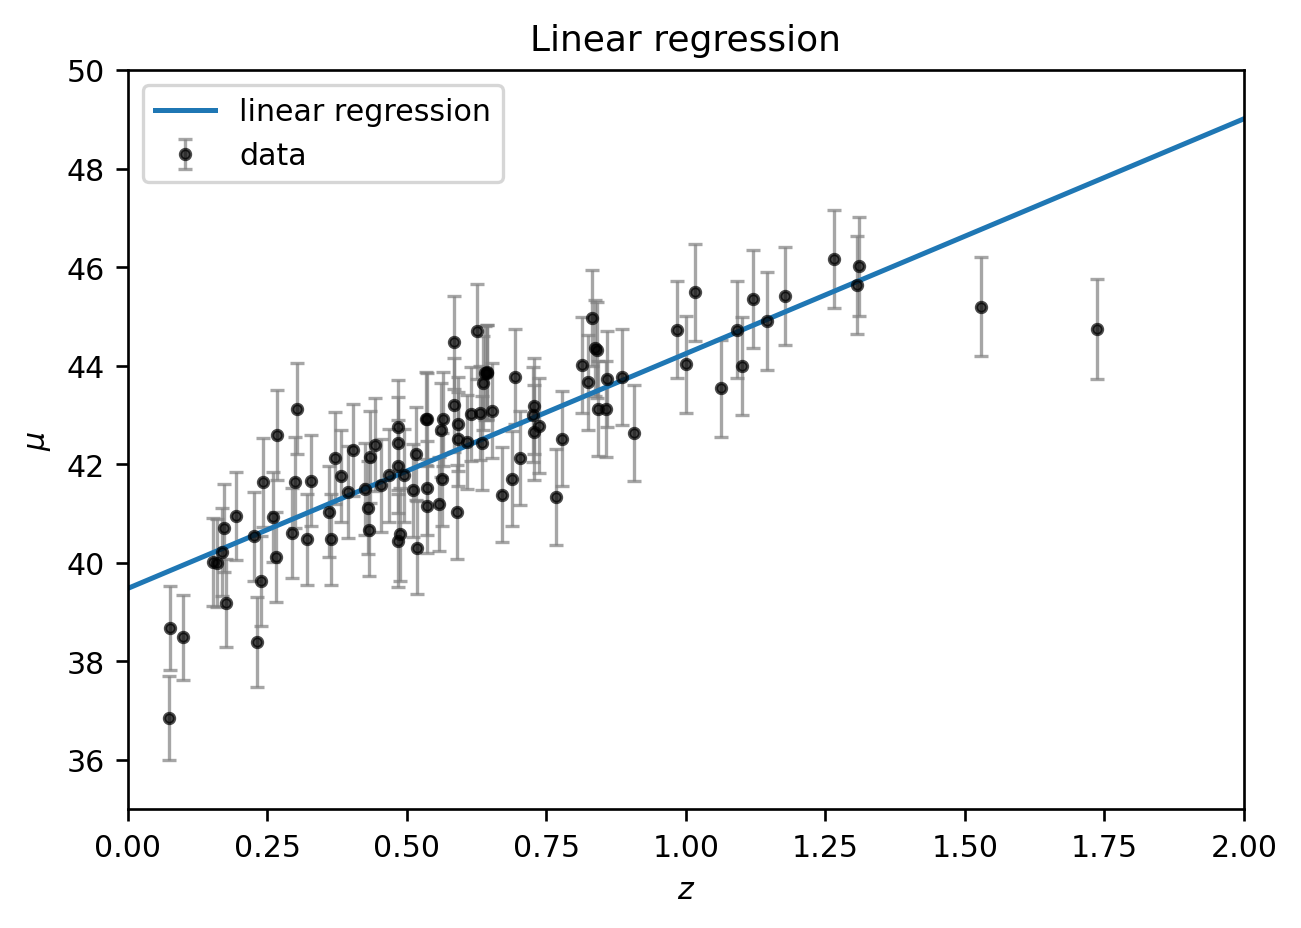

In [4]:
#Plot results
z_grid = np.linspace(0,2,100)[:, None]
mu_linear = linreg.predict(z_grid)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', 
             ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
plt.plot(z_grid, mu_linear,label='linear regression')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.title('Linear regression');

## Polynomial

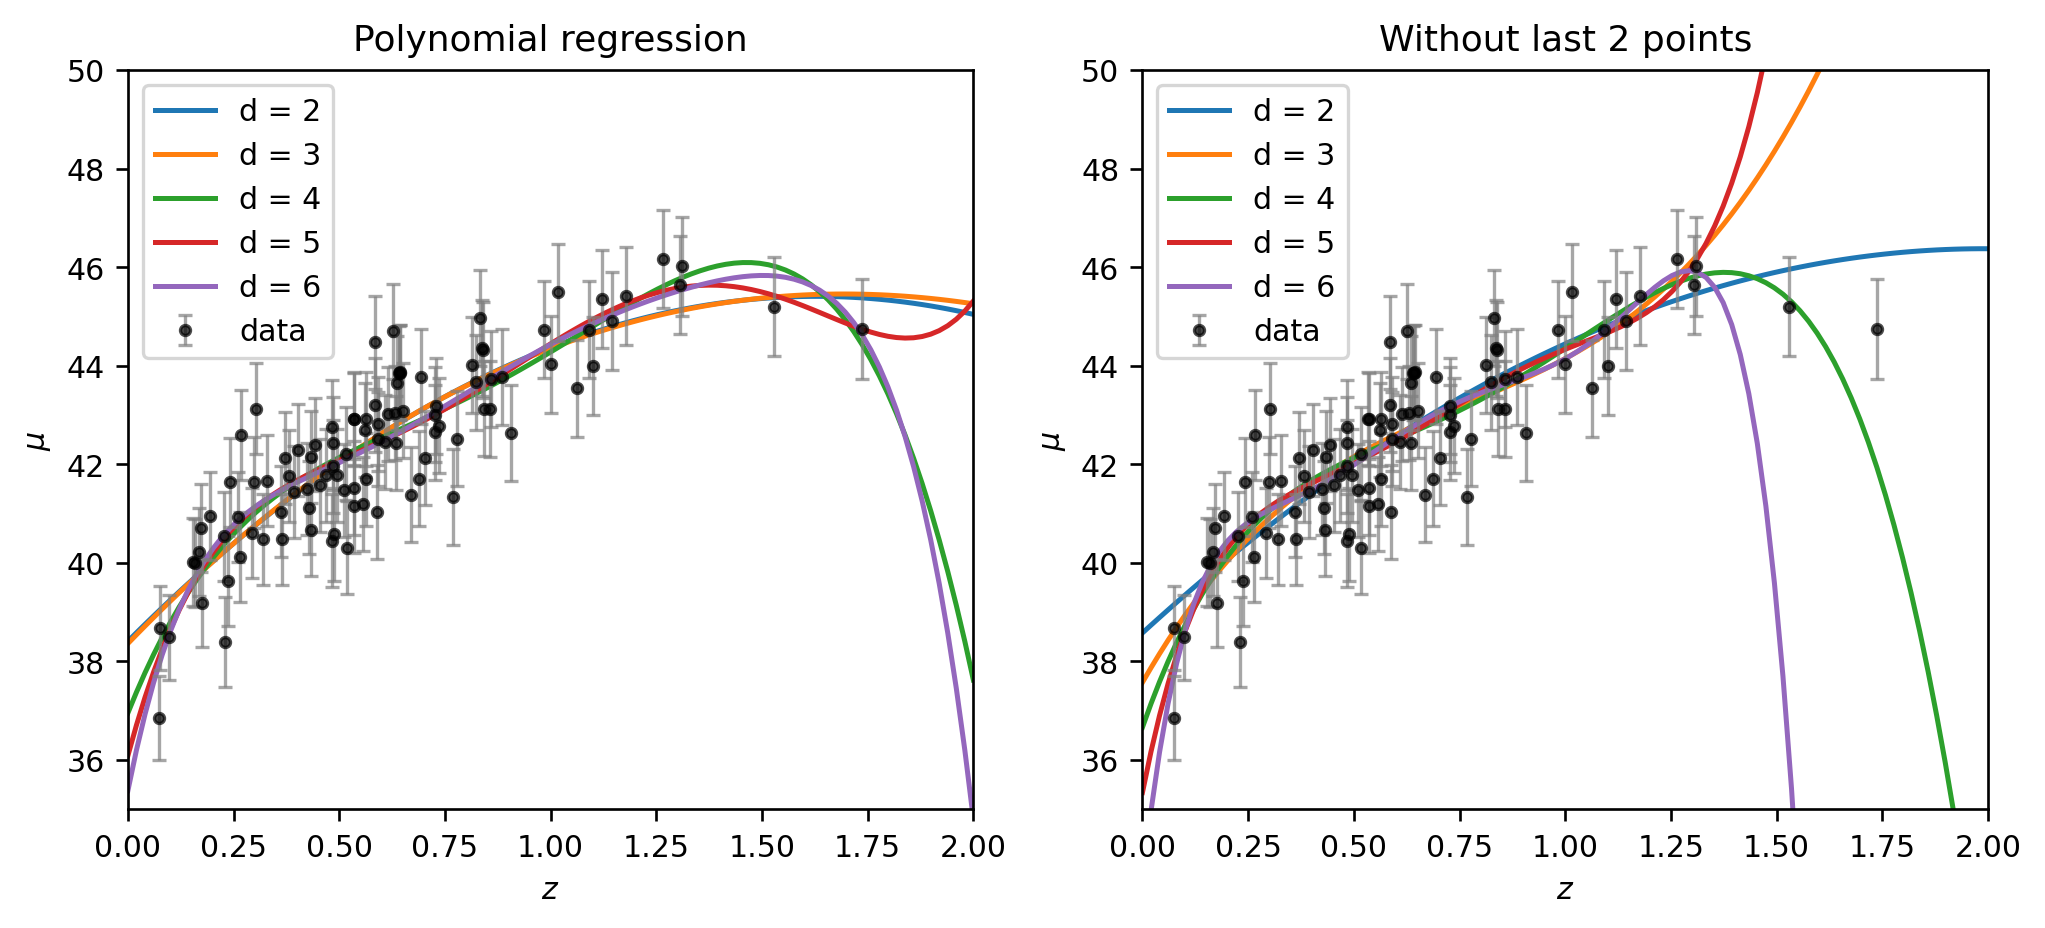

In [5]:
#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

degrees = np.arange(2, 7)
fig = plt.figure()

ax = fig.add_subplot(121)   

for d in degrees:
    polyreg = PolynomialRegression(d)
    polyreg.fit(z, mu_sample, dmu)
    mu_poly = polyreg.predict(z_grid)
    
    ax.plot(z_grid, mu_poly, label='d = %i' % d)

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
ax.legend()
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Polynomial regression');

ax = fig.add_subplot(122)   

for d in degrees:
    polyreg = PolynomialRegression(d)
    polyreg.fit(z[:-2], mu_sample[:-2], dmu[:-2])
    mu_poly = polyreg.predict(z_grid)
    
    ax.plot(z_grid, mu_poly, label='d = %i' % d)

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
ax.legend()
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Without last 2 points');

- Linear model clearly underfits data.
- d=2,3 fit quite well, maybe slight underfit
- d=4 captures also the last points well
- d=5,6 no great advantage by increasing model parameters (overfit?)

## Function Basis
We use gaussians as basis

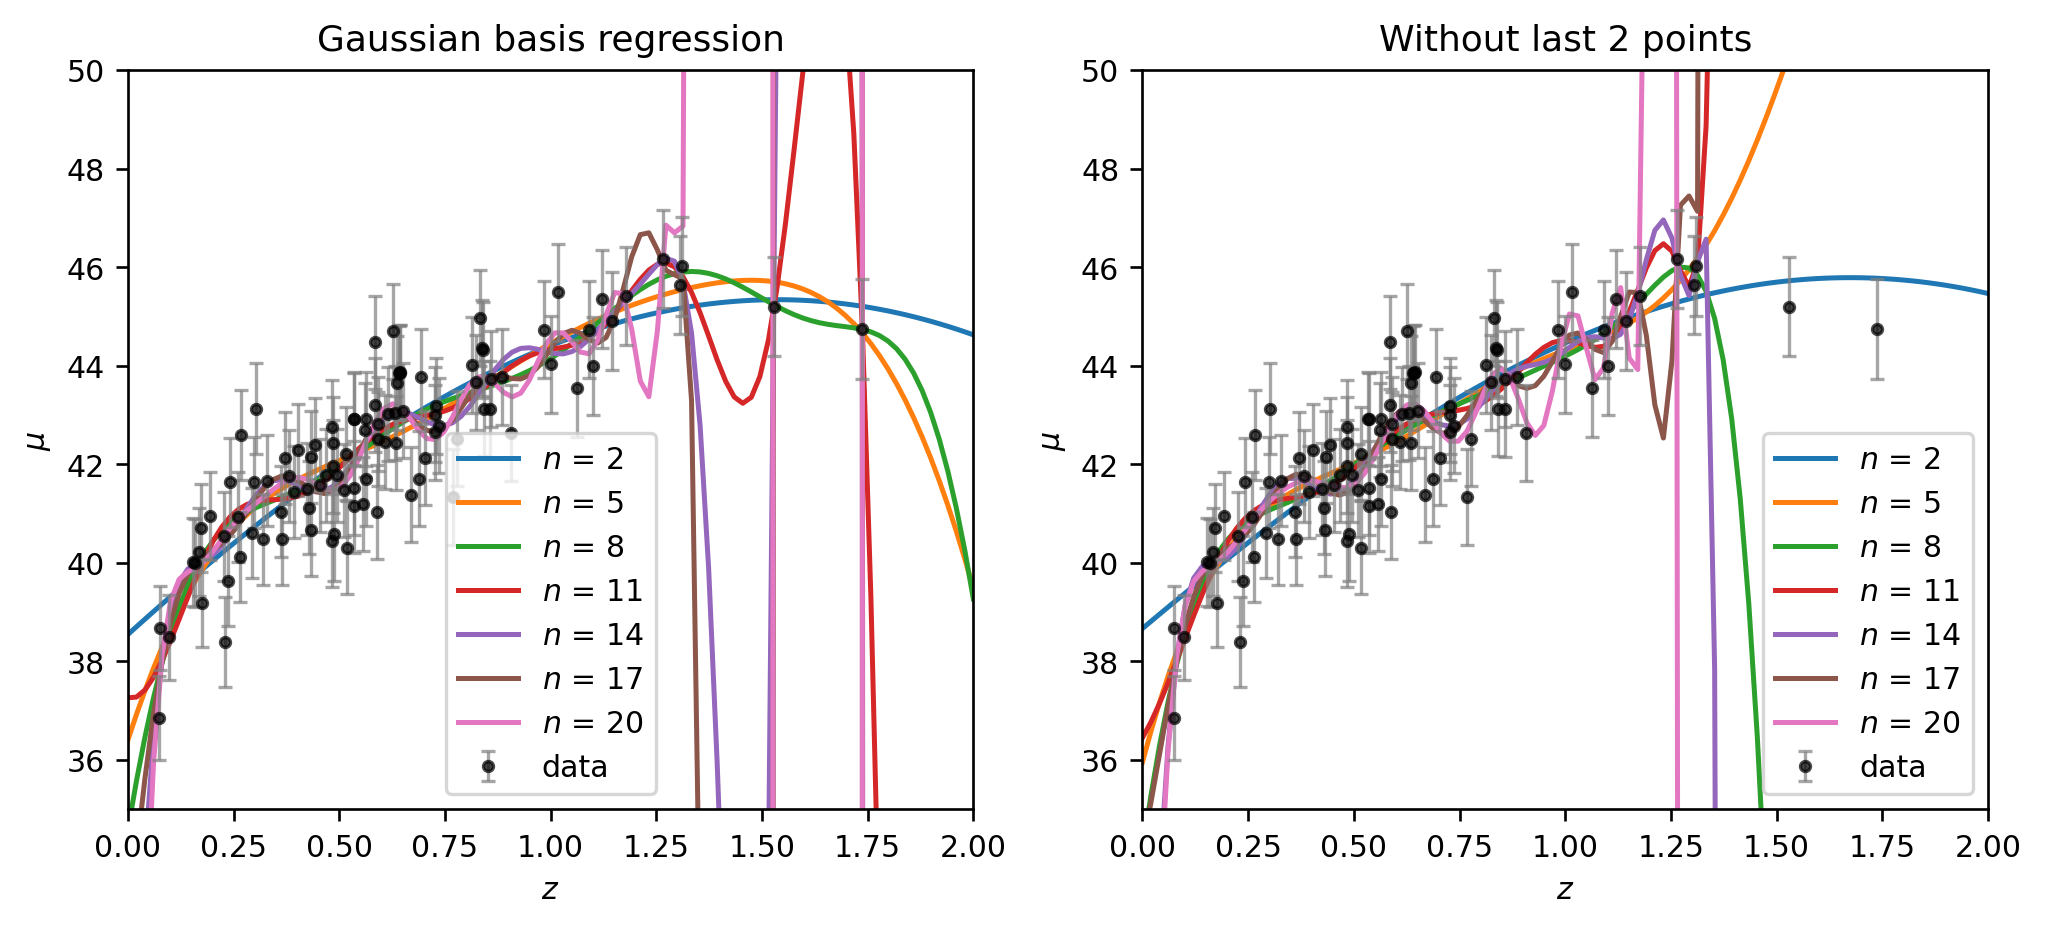

In [6]:
n_basis = np.arange(2, 21, 3)
fig = plt.figure()

ax = fig.add_subplot(121)   

for n in n_basis:
    gauss_mu = np.linspace(0, 2, n)[:, np.newaxis]
    sigma = gauss_mu[1] - gauss_mu[0]
    basis_model = BasisFunctionRegression(basis_func='gaussian', mu = gauss_mu, sigma = sigma)
    basis_model.fit(z, mu_sample, dmu)
    mu_basis = basis_model.predict(z_grid)
    
    ax.plot(z_grid, mu_basis, label=r'$n$ = %.i' % n)
    
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
ax.legend()
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Gaussian basis regression');

ax = fig.add_subplot(122)   

for n in n_basis:
    gauss_mu = np.linspace(0, 2, n)[:, np.newaxis]
    sigma = gauss_mu[1] - gauss_mu[0]
    basis_model = BasisFunctionRegression(basis_func='gaussian', mu = gauss_mu, sigma = sigma)
    basis_model.fit(z[:-2], mu_sample[:-2], dmu[:-2])
    mu_basis = basis_model.predict(z_grid)
    
    ax.plot(z_grid, mu_basis, label=r'$n$ = %.i' % n)
    
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
ax.legend()
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Without last 2 points');

## Kernel Regression

/home/fra/.local/lib/python3.8/site-packages/astroML/linear_model/kernel_regression.py:52: RuntimeWarning: invalid value encountered in true_divide
  return (K * self.y).sum(1) / K.sum(1)


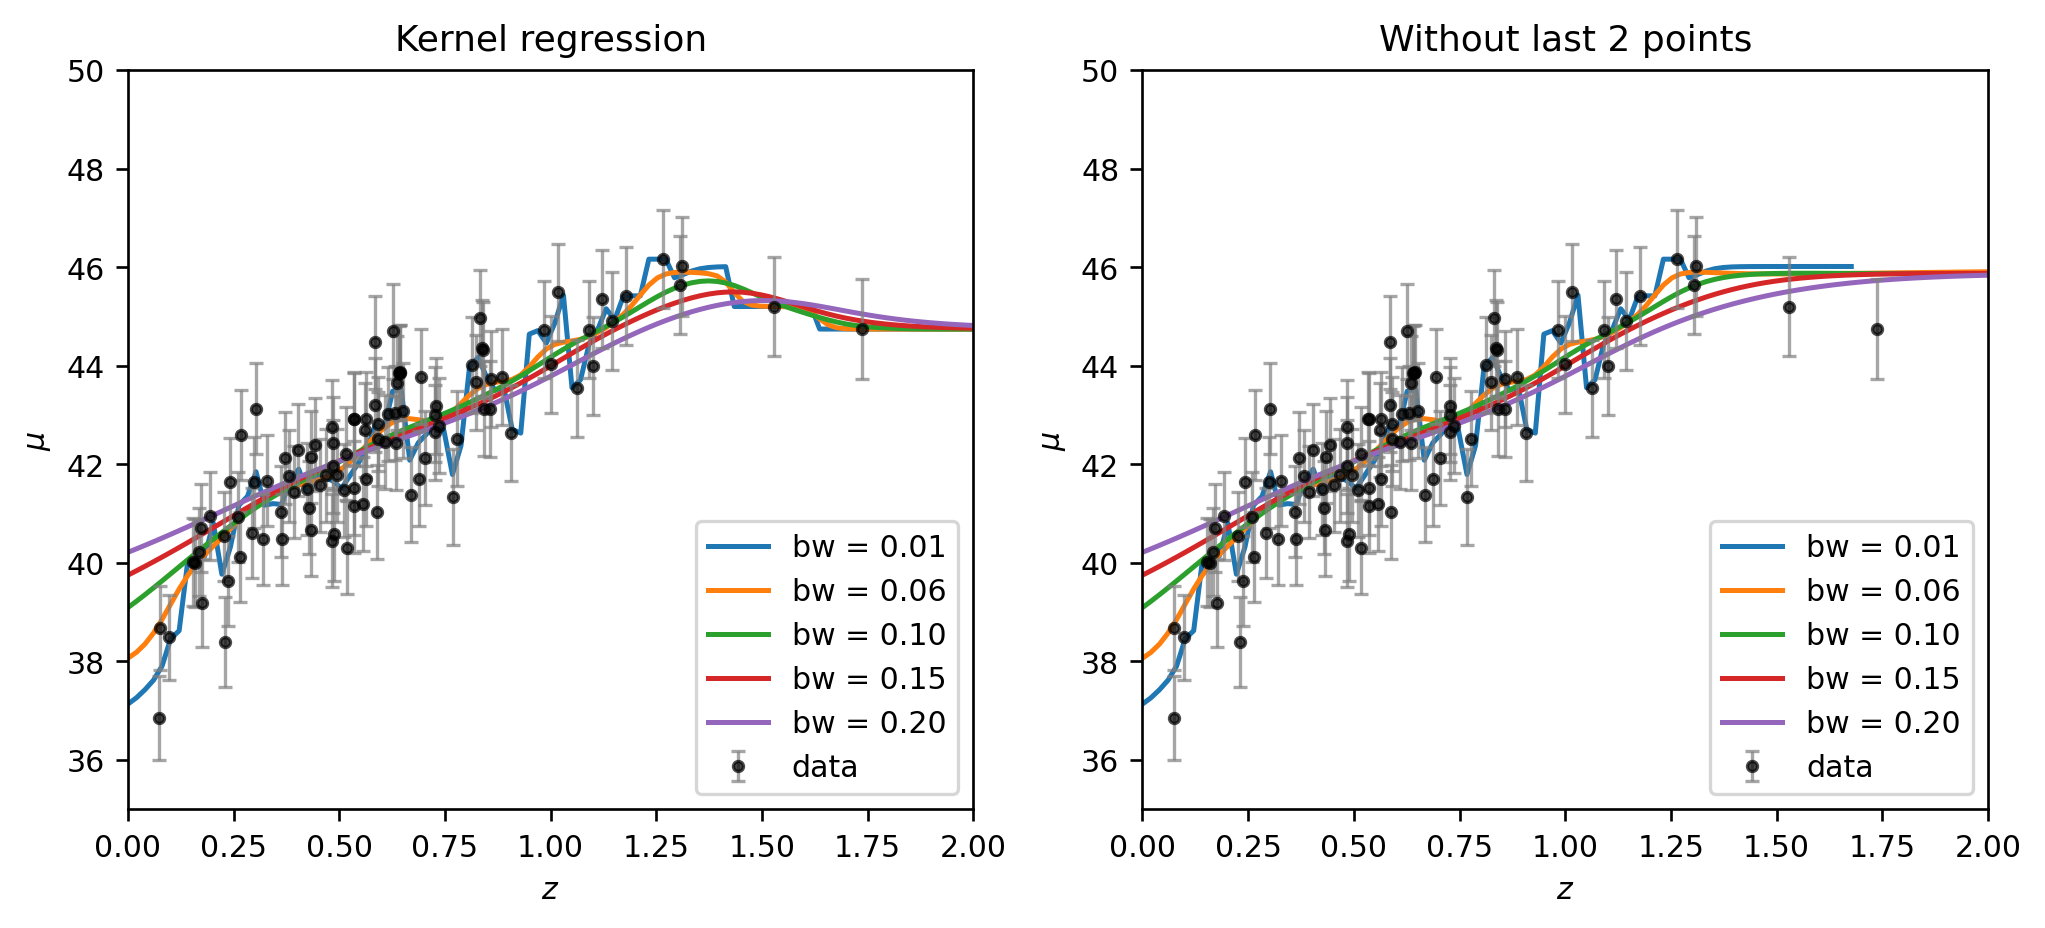

In [7]:
bw_list= np.linspace(0.01, 0.2, 5)

fig = plt.figure()

ax = fig.add_subplot(121)   

for bw in bw_list:
    
    kernel = NadarayaWatson(kernel='gaussian', h=bw)
    kernel.fit(z, mu_sample)
    mu_kernel = kernel.predict(z_grid)
    
    ax.plot(z_grid, mu_kernel, label= 'bw = %.2f' % bw)
    
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
ax.legend()
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Kernel regression');

ax = fig.add_subplot(122)   

for bw in bw_list:
    
    kernel = NadarayaWatson(kernel='gaussian', h=bw)
    kernel.fit(z[:-2], mu_sample[:-2])
    mu_kernel = kernel.predict(z_grid)
    
    ax.plot(z_grid, mu_kernel, label= 'bw = %.2f' % bw)
    
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
ax.legend()
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Without last 2 points');

# Cross validation

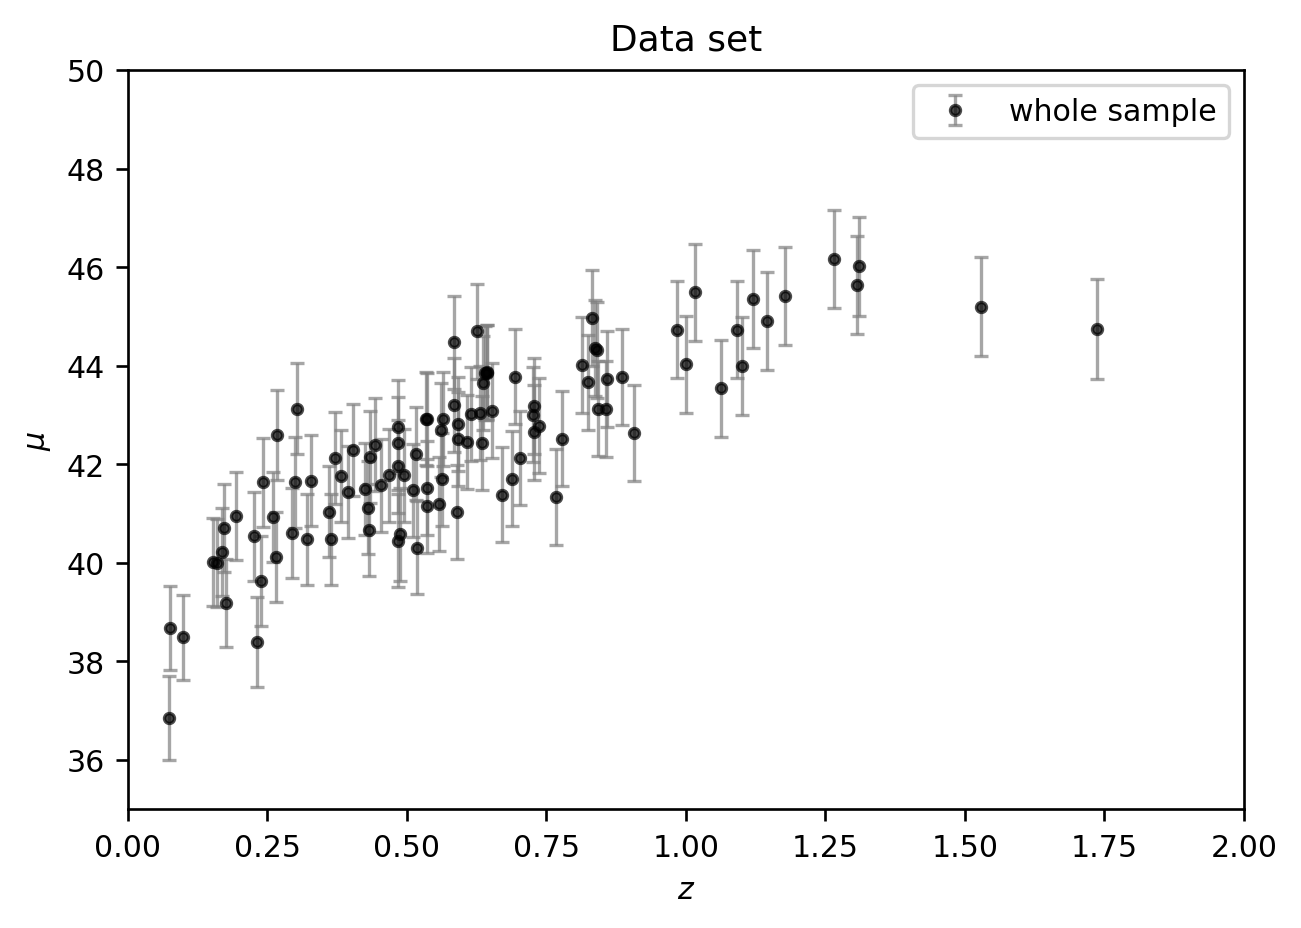

In [8]:
z_sample, mu_sample, dmu = np.asarray(generate_mu_z(100, random_state=1234))

# #sorting the sample to ease access
# args = np.argsort(z_sample)
# z_sample = z_sample[args]
# mu_sample = mu_sample[args]
# dmu = dmu[args]

#Set TRUE for leaving 20% points as test set, FALSE to use all points
if False:
    z_train, z_test, mu_train, mu_test, dmu_train, dmu_test = \
        train_test_split(z_sample, mu_sample, dmu, test_size = 0.20, random_state=400)

    args = np.argsort(z_test)
    z_test = z_test[args]
    mu_test = mu_test[args]
    dmu_test = dmu_test[args]
    
    scores = [] #stores regressors scoring against test set

    def score_regressor(regressor):
        mu_pred = regressor.predict(z_test[:,None])
        score = [r2_score(mu_test, mu_pred), 
                mean_squared_error(mu_test, mu_pred)]
        return score

else:
    z_train = z_sample
    mu_train = mu_sample
    dmu_train = dmu

z = z_sample[:,None] #sklearn way

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(6, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', 
             ecolor='gray', lw=1,label='whole sample',capsize = 2, alpha=0.7)
# plt.scatter(z_test,mu_test, label='test set')

plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.title('Data set');

We propose two CV algorithms: 
- cycling first on k-folds, and then on params: obtain list of best parameters for each k-fold, chosen by least validation error
- cycling first on parameter space, then on k-folds: obtain best parameter chosen by least k-averaged validation error. This seems to be the praxis in ML, but did not find reliable sources

In [12]:
################################ Error function
def error(y, y_fit):
    return np.sqrt(np.mean((y - y_fit)**2))

##################################### CV cycling on folds first
def K_cross_val_fit(K,model_func, param_list): 
    ''' 
    CV cycling first on k-folds, and then on params.
    
    Arguments: 
    K = folds,
    Model = func(p),
    param_list = grid of values of p to investigate
    
    Returns:

    err_train_list: list of err_train for each fold, tested with its best param
    err_val_list: list of err_validation for each fold, tested with its best param
    best_p_list: list of best parameters for each k-fold, chosen by least validation error
    '''
    np.random.seed(404)
    # Create folds
    args = np.arange(0, len(z_train))
    np.random.shuffle(args)
    z_random = z_train[args]
    mu_random = mu_train[args]
    dmu_random = dmu_train[args]

    z_folds = np.asarray(np.split(z_random, K))
    mu_folds = np.asarray(np.split(mu_random, K))
    dmu_folds = np.asarray(np.split(dmu_random, K))

    k_list = np.arange(K)
    
    # Cross validation and fit
    best_p_list = []
    err_train_list = []
    err_val_list =[]
    
    start = 0
    for k in k_list: # Cycle on the hyperparameters
        
        traincv_indexes = k_list[k_list != k]
        
        z_val = z_folds[k][:, None]
        z_traincv = z_folds[traincv_indexes].flatten()[:, None]
        
        mu_val = mu_folds[k]
        mu_traincv = mu_folds[traincv_indexes].flatten()
        
        dmu_val = z_folds[k]
        dmu_traincv = dmu_folds[traincv_indexes].flatten()
        err_train = []
        err_val = []

        for p in param_list: 
            model = model_func(p)
            
            model.fit(z_traincv, mu_traincv, dmu_traincv) # Fit the model on this fold, cycling over parameter space
            mu_train_fit = model.predict(z_traincv)
            mu_val_fit = model.predict(z_val)
            
            err_train.append(error(mu_traincv, mu_train_fit))
            err_val.append(error(mu_val, mu_val_fit))
            
        argbest = np.argmin(err_val)        
        best_p_list.append(param_list[argbest])
        err_train_list.append(err_train)
        err_val_list.append(err_val)

    # best_par = np.median(best_p_list)
    
    return err_train_list, err_val_list, best_p_list



##################################### CV cycling on params first
def K_cross_val_fit_PARAM_FIRST(K,model_func, param_list): 
    ''' 
    CV cycling first on parameter space, then on k-folds
    
    Arguments: 
    K = folds,
    Model = func(p),
    param_list = grid of values of p to investigate
    
    Returns:
    err_train_list: list of err_train for each param value, averaged over k-folds
    err_val_list: list of err_validation for each param value, averaged over k-folds
    best_par: best parameter chosen by least k-averaged validation error
    
    '''
    np.random.seed(404)
    # Create folds
    args = np.arange(0, len(z_train))
    np.random.shuffle(args)
    z_random = z_train[args]
    mu_random = mu_train[args]
    dmu_random = dmu_train[args]

    z_folds = np.asarray(np.split(z_random, K))
    mu_folds = np.asarray(np.split(mu_random, K))
    dmu_folds = np.asarray(np.split(dmu_random, K))

    k_list = np.arange(K)
    
    # Cross validation and fit
    best_p_list = []
    err_train_list = []
    err_val_list =[]
    
    start = 0
    for p in param_list: 
        model = model_func(p)
        
        err_train = []
        err_val = []
        
        for k in k_list: # Cycle on the hyperparameters
            
            traincv_indexes = k_list[k_list != k]
            
            z_val = z_folds[k][:, None]
            z_traincv = z_folds[traincv_indexes].flatten()[:, None]
            
            mu_val = mu_folds[k]
            mu_traincv = mu_folds[traincv_indexes].flatten()
            
            dmu_val = z_folds[k]
            dmu_traincv = dmu_folds[traincv_indexes].flatten()

            model.fit(z_traincv, mu_traincv, dmu_traincv)  # Fit the model in this point of parameter space, cycling over folds
            mu_train_fit = model.predict(z_traincv)
            mu_val_fit = model.predict(z_val)
            
            err_train.append(error(mu_traincv, mu_train_fit))
            err_val.append(error(mu_val, mu_val_fit))
            
        err_train_list.append(np.mean(err_train))
        err_val_list.append(np.mean(err_val))

    arg = np.argmin(err_val_list)
    best_par = param_list[arg]
    
    return err_train_list, err_val_list, best_par



############################## Plotting learning curves

def learning_curve(model):
    ''' Argument model = Regressor(best_parameter)'''
    z_t, z_val, mu_t, mu_val, dmu_t, dmu_val = \
        train_test_split(z_sample, mu_sample, dmu, test_size = 0.30, random_state=42)

    N_list = np.arange(2, len(z_sample) + 1, 2)

    err_train = []
    err_val = []

    z_sample_sk = z_sample[:,None]
    z_t_sk = z_t[:,None]
    z_val_sk = z_val[:,None]

    for n in N_list:
        model.fit(z_sample_sk[:n], mu_sample[:n], dmu[:n])
        mu_train_fit = model.predict(z_sample_sk[:n])
        mu_val_fit = model.predict(z_val_sk)
        err_train.append(error(mu_sample[:n], mu_train_fit))
        err_val.append(error(mu_val, mu_val_fit))

    plt.plot(N_list, err_train, c='k', label='training')
    plt.plot(N_list, err_val, c='k', ls='--', label='validation')

    plt.axvline(len(z_t), c = 'k', ls = ':', label = 'cv training size')
    plt.xlabel(r'$N_{train}$')
    plt.ylabel('error')
    plt.ylim(0, 2)
    plt.legend()
    plt.show()

## Polynomial

5


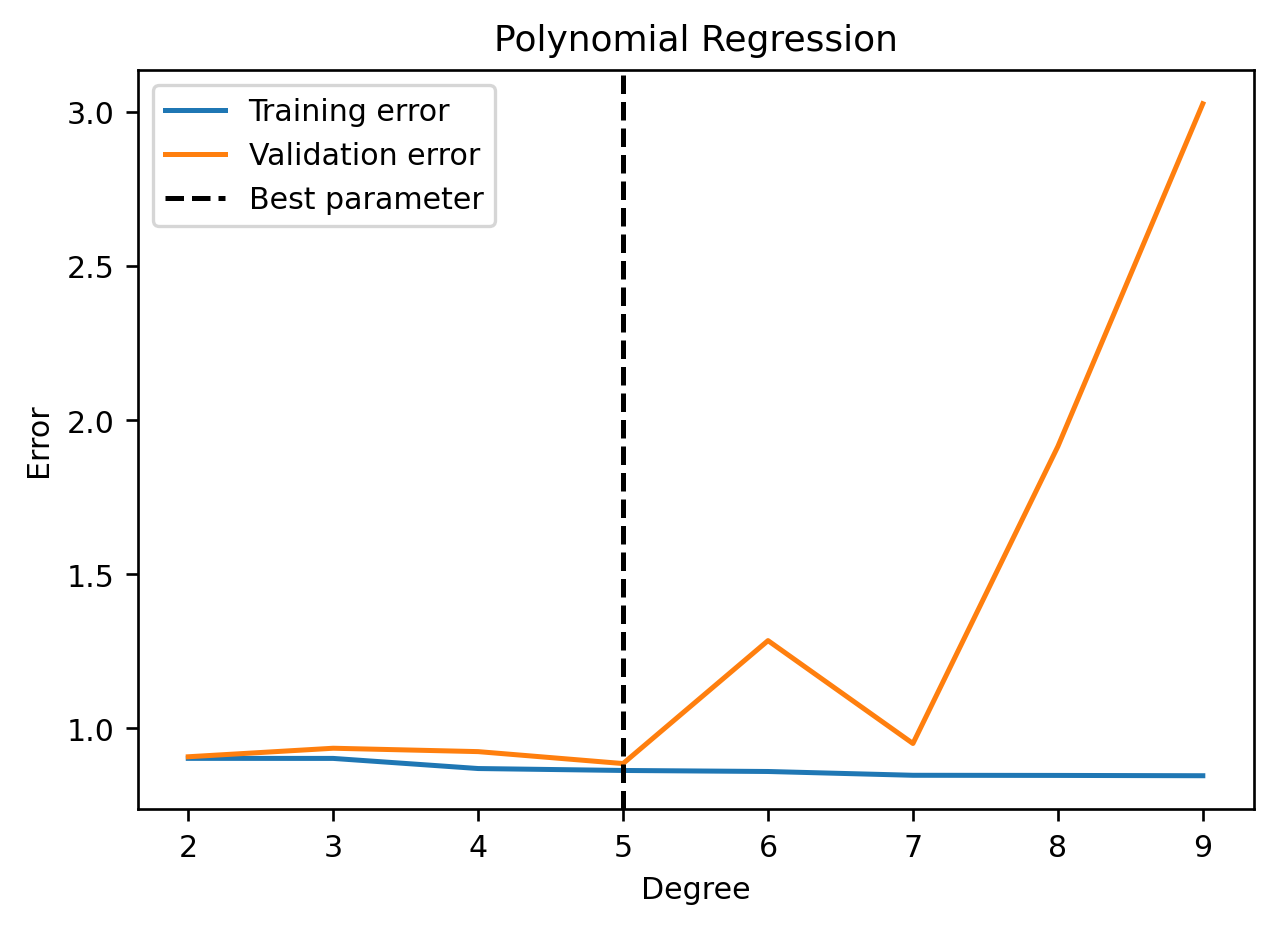

In [21]:
deg_list = np.arange(2, 10)
K = 20

############### TRUE = cycle on parameters first, FALSE = cycle on k-folds first
if True:
    err_train, err_val, best_deg = K_cross_val_fit_PARAM_FIRST(K,PolynomialRegression,deg_list)

    print(best_deg)

    plt.plot(deg_list,err_train, label='Training error' )
    plt.plot(deg_list,err_val, label='Validation error')
    plt.axvline(best_deg, ls='--', color='k', label='Best parameter')
    plt.title('Polynomial Regression')
    plt.xlabel('Degree')
    plt.ylabel('Error')
    plt.legend();

else:
    err_train, err_val, best_deg_list = K_cross_val_fit(K,PolynomialRegression,deg_list)

    best_deg = int(np.median(best_deg_list))
    print(best_deg_list)
    print(best_deg)

    i=9
    plt.plot(deg_list,err_train[i], label='Training error' )
    plt.plot(deg_list,err_val[i], label='Validation error')
    plt.axvline(best_deg, ls='--', color='k', label='Best parameter')
    plt.title('Polynomial Regression')
    plt.xlabel('Degree')
    plt.ylabel('Error')
    plt.legend();


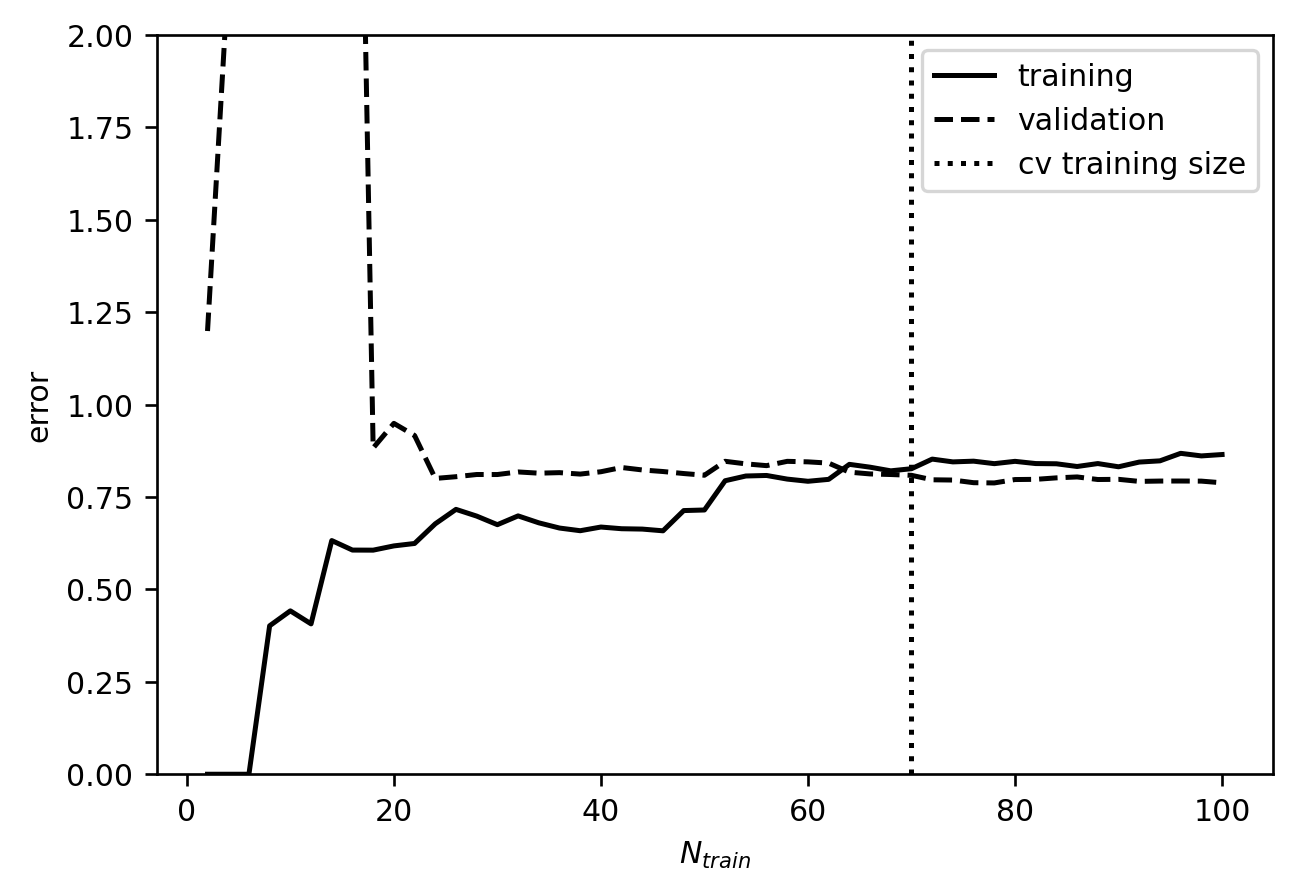

In [17]:
# Plot learning curve
model = PolynomialRegression(best_deg)
   
learning_curve(model)

## Function basis

In [23]:
def BasisFunctionReg_func(n):
    gauss_mu = np.linspace(0, 2, n)[:, np.newaxis]
    sigma = gauss_mu[1] - gauss_mu[0]
    return BasisFunctionRegression(basis_func='gaussian', mu = gauss_mu, sigma = sigma)

Best parameter = 4


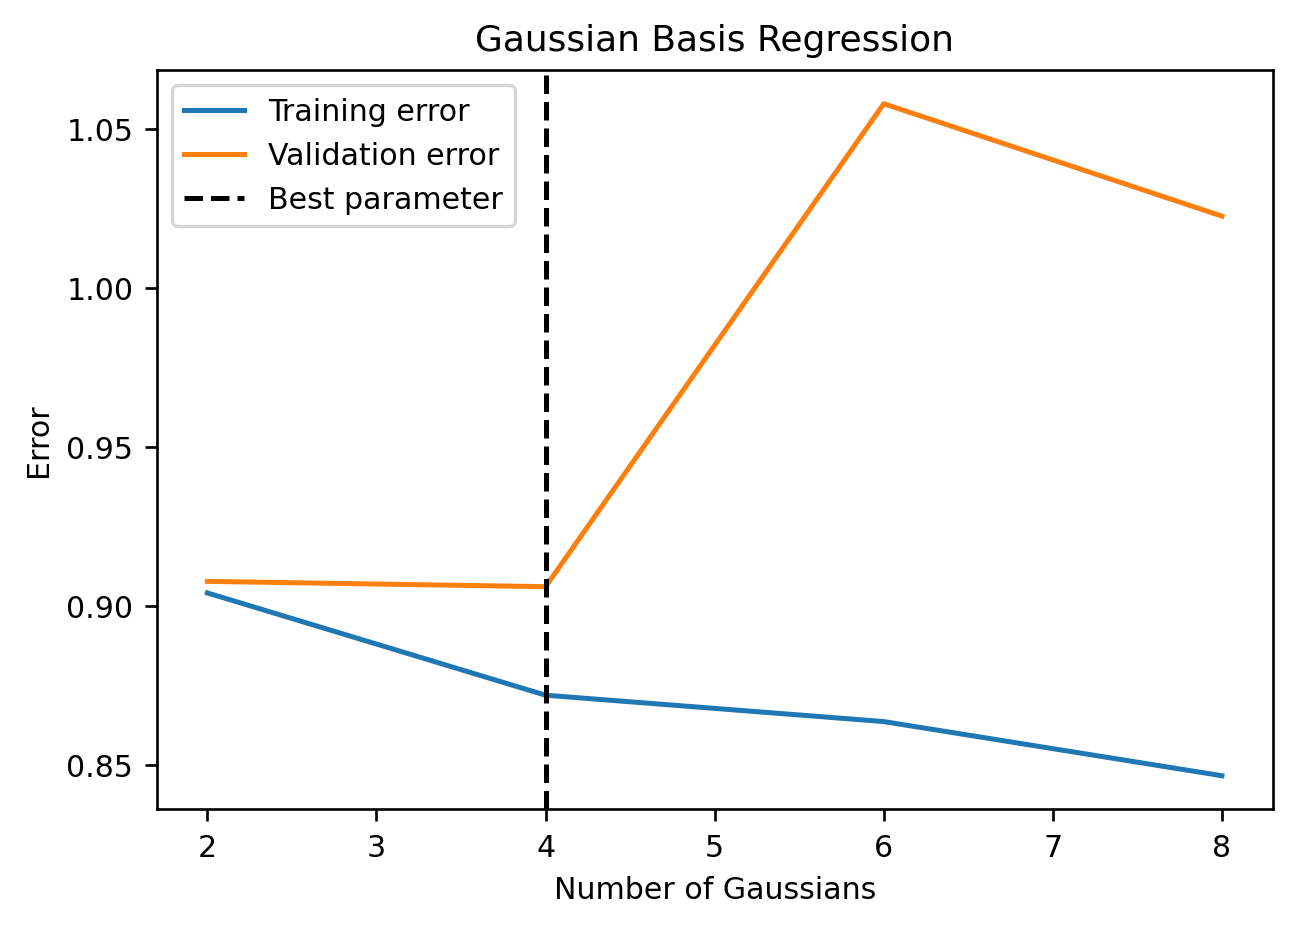

In [31]:
n_list = np.arange(2, 10, 2)
K = 20

############### TRUE = cycle on parameters first, FALSE = cycle on k-folds first
if True:
    err_train, err_val, best_n = K_cross_val_fit_PARAM_FIRST(K,BasisFunctionReg_func,n_list)

    print(f'Best parameter = {best_n}')

    plt.plot(n_list,err_train, label='Training error' )
    plt.plot(n_list,err_val, label='Validation error')
    plt.axvline(best_n, ls='--', color='k', label='Best parameter')
    plt.title('Gaussian Basis Regression')
    plt.xlabel('Number of Gaussians')
    plt.ylabel('Error')
    plt.legend();

else:
    err_train_mean, err_val_mean, best_n_list = K_cross_val_fit(K,BasisFunctionReg_func,n_list)

    best_n = int(np.median(best_n_list))
    print(best_n_list)
    print(best_n)

    i=8
    print(f'Best parameter = {best_n}')
    plt.plot(n_list,err_train_mean[i], label='Training error' )
    plt.plot(n_list,err_val_mean[i], label='Validation error')
    plt.axvline(best_n, ls='--', color='k', label='Best parameter')
    plt.title('Gaussian Basis Regression')
    plt.xlabel('Number of Gaussians')
    plt.ylabel('Error')
    plt.legend();


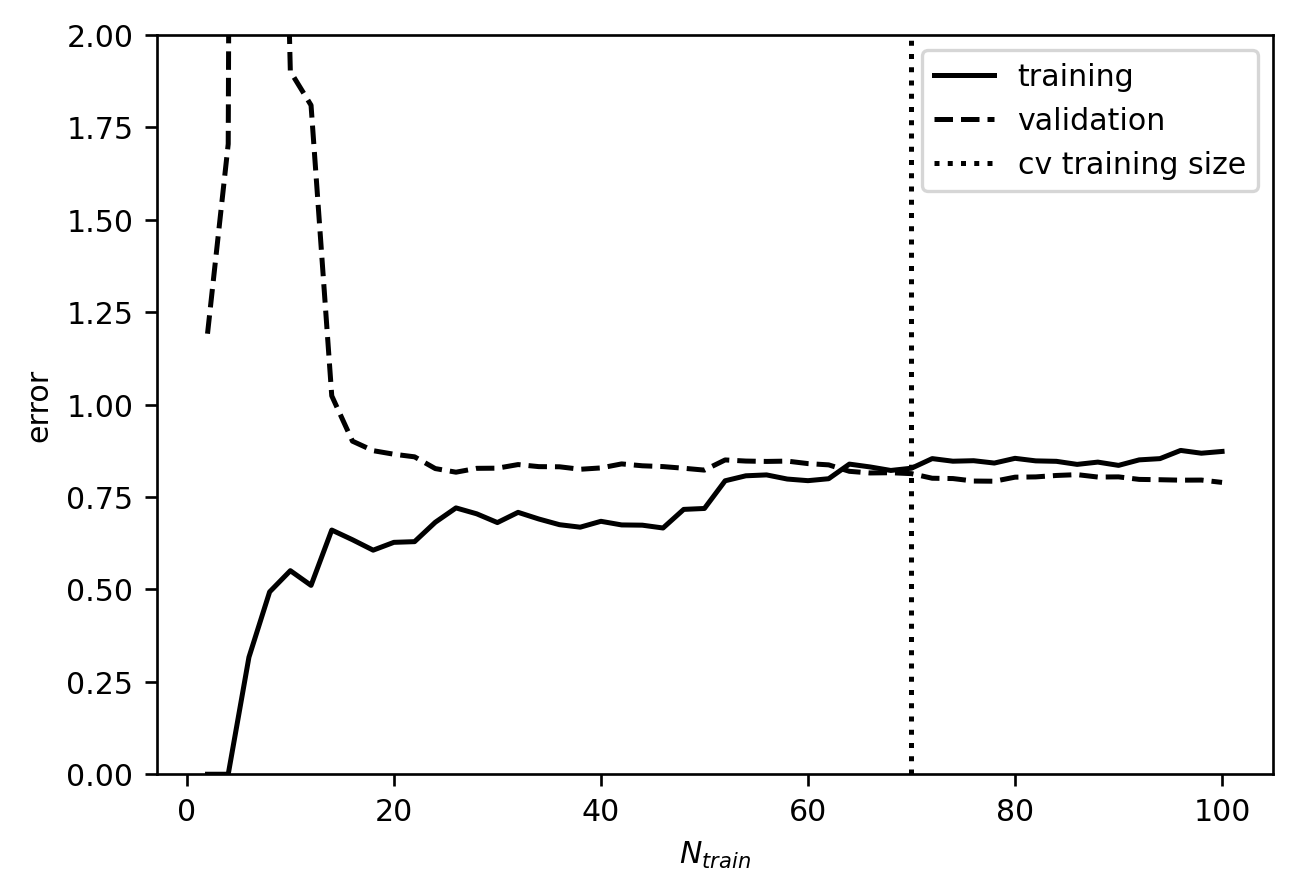

In [32]:
model = BasisFunctionReg_func(best_n)

# Plot learning curve   
learning_curve(model)

## Kernel regression

In [34]:
def KernelRegression_func(bw):
    return NadarayaWatson(kernel='gaussian', h=bw)

Best parameter = 0.03571428571428572


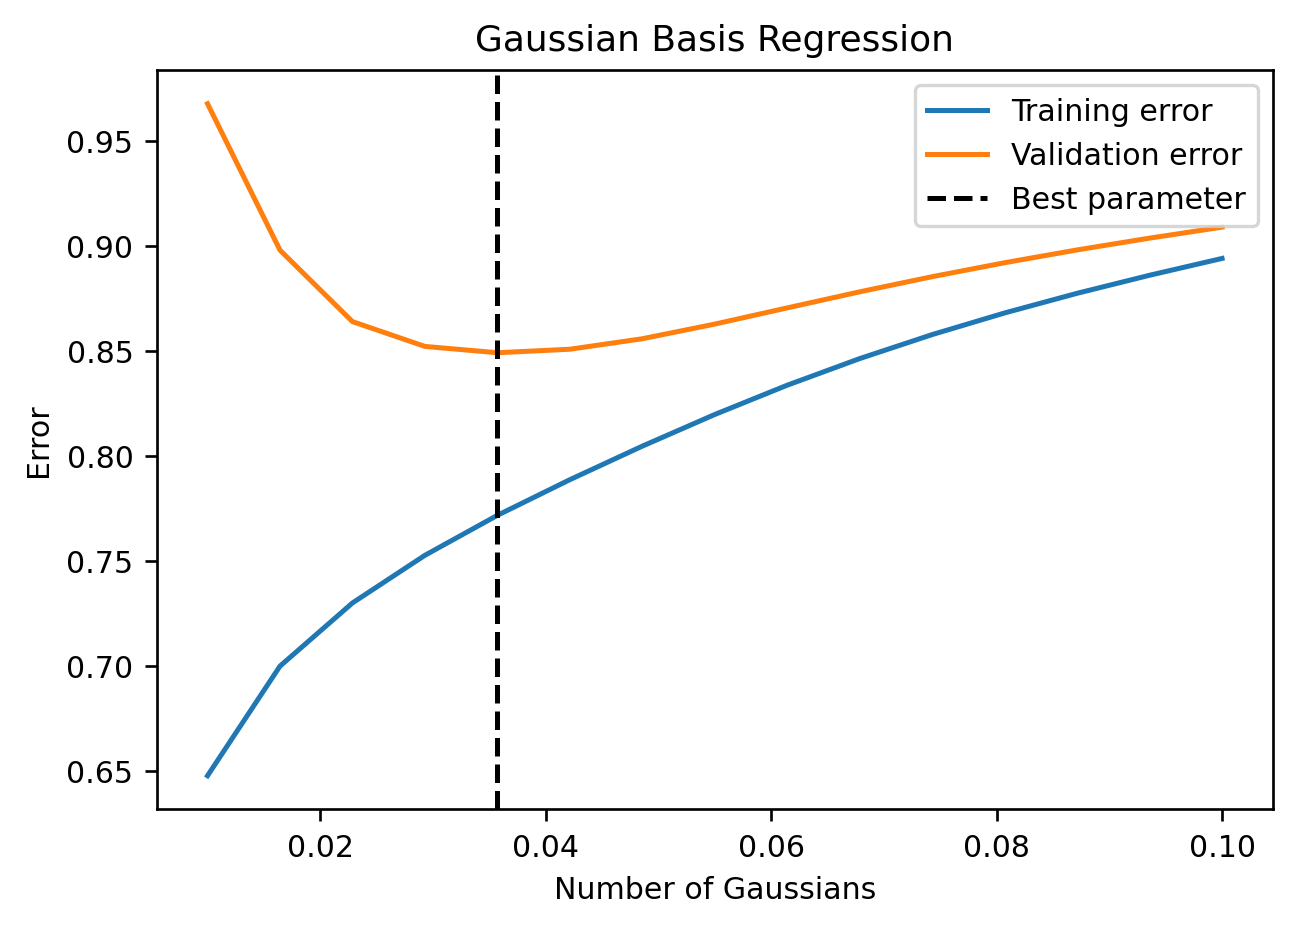

In [35]:
bw_list= np.linspace(0.01, 0.1, 15)
K = 20

############### TRUE = cycle on parameters first, FALSE = cycle on k-folds first
if True:
    err_train, err_val, best_bw = K_cross_val_fit_PARAM_FIRST(K,KernelRegression_func,bw_list)

    print(f'Best parameter = {best_bw}')

    plt.plot(bw_list,err_train, label='Training error' )
    plt.plot(bw_list,err_val, label='Validation error')
    plt.axvline(best_bw, ls='--', color='k', label='Best parameter')
    plt.title('Gaussian Basis Regression')
    plt.xlabel('Number of Gaussians')
    plt.ylabel('Error')
    plt.legend();

else:
    err_train, err_val, best_bw_list = K_cross_val_fit(K,KernelRegression_func, bw_list)

    best_bw = np.median(best_bw_list)
    print(best_bw_list)
    print(best_bw)

    i=5
    print(f'Best parameter = {best_bw}')
    plt.plot(bw_list,err_train[i], label='Training error' )
    plt.plot(bw_list,err_val[i], label='Validation error')
    plt.axvline(best_bw, ls='--', color='k', label='Best parameter')
    plt.title('Kernel Regression')
    plt.xlabel('Bandwidth')
    plt.ylabel('Error')
    plt.legend();




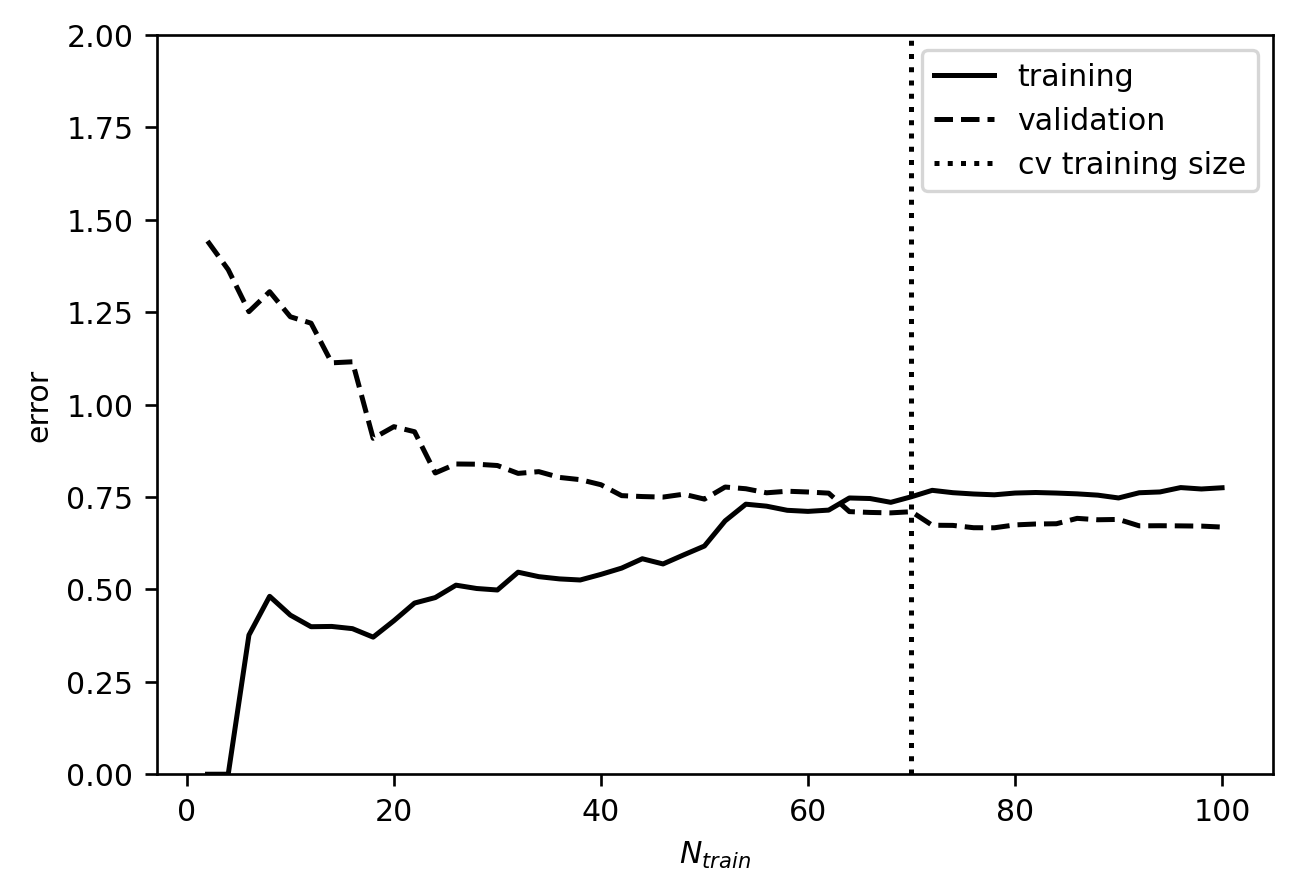

In [36]:
model = KernelRegression_func(best_bw)

# Plot learning curve   
learning_curve(model)

# Visual comparison

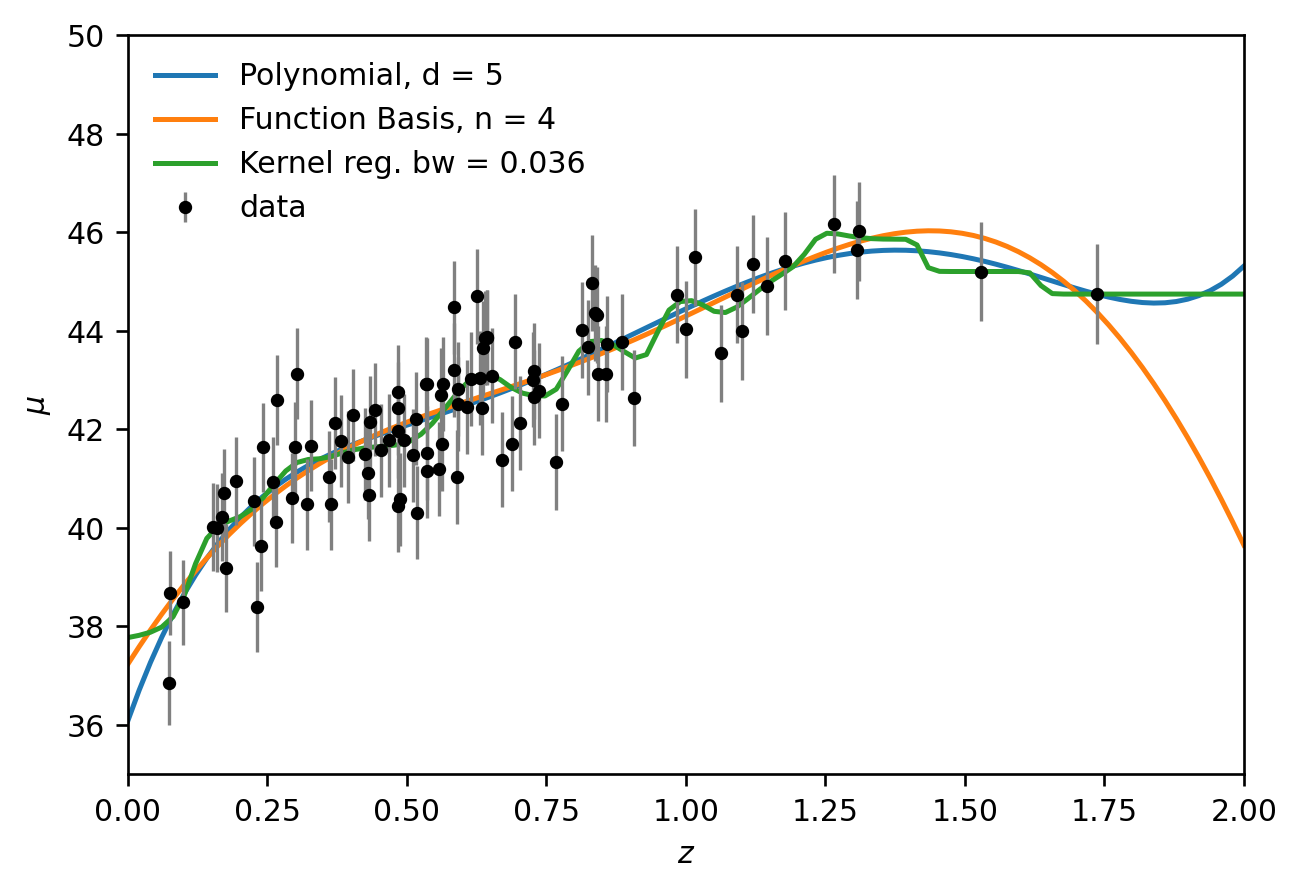

In [37]:
z_grid = np.linspace(0,2,100)[:, None]

models = [PolynomialRegression, BasisFunctionReg_func, KernelRegression_func]
params = [best_deg, best_n, best_bw]
labels = [f'Polynomial, d = {best_deg}', f'Function Basis, n = {best_n}', f'Kernel reg. bw = {best_bw:.2}']

for mod, best_p, label in zip(models,params, labels):
    
    model = mod(best_p)
    model.fit(z, mu_sample, dmu)
    mu_poly = model.predict(z_grid)
    plt.plot(z_grid, mu_poly, label=label)


plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()